In [5]:
## Using PlanetMath rank data
with open('/home/luis/rank_solution_1.txt', 'r') as json_fobj:
    rank_sol = json.load(json_fobj)
    
num_levels = int(max(rank_sol.values()))+1
# declare the list to allow appending
pm_level2words = [[] for _ in range(num_levels)]
for k,v in rank_sol.items():
    pm_level2words[int(v)].append('_'.join(k.lower().split()))

for level, word_list in enumerate(pm_level2words):
    print(level, len(word_list), word_list[:5])

level2words = pm_level2words

0 1 ['t']
1 7 ['bijection', 'wolf_prize', 'crossing_number', 'strong_law_of_small_numbers', 'lucas_numbers']
2 1 ['countable']
3 1 ['generated_by']
4 1 ['ample']
5 2 ['argument', 'object']
6 2 ['term', 'maximal']
7 5 ['order', 'semiperimeter', 'exactly_determined', 'c', 'bounded']
8 5 ['d', 'chauvenet_prize', 'generalized_zeta_function', 'chu_transform', 'bound']
9 10 ['dirac_sequence', 'b', 'collection', 'binary_operation', 'square']
10 12 ['mean', 'closed', 'mathematical_association_of_america', 'ada_lovelace', 'star']
11 12 ['strict', 'synthetic_division', 'open', 'addition', 'cartesian_product']
12 22 ['tamely_imbedded', 'full_subgroup', 'product', 'borel_isomorphism', 'equivalence_class']
13 8 ['relation', 'induce', 'identity', 'left_function_notation', 'euclidean']
14 17 ['variable', 'induced', 'disjoint_disks_property', 'side', 'clique_number']
15 28 ['zero', 'additive_function', 'roman_numerals', 'real_number', 'unit']
16 40 ['von_neumann_integer', 'null_semigroup', 'negative',

In [6]:
# Get vocabulary from WordNet + labels for each section
def read_word_dict():
    result_dict = dict([(str(level), word_list[:50] + word_list[50::10]) for level, word_list in enumerate(level2words)])
    return result_dict

def HSVToRGB(h, s, v):
    (r, g, b) = colorsys.hsv_to_rgb(h, s, v)
    return (int(255*r), int(255*g), int(255*b))

def get_colors(word_dict):
    labels = word_dict.keys()
    huePartition = 1.0 / (len(labels) + 1)
    return dict(zip(labels, [HSVToRGB(huePartition * value, 1.0, 1.0) for value in range(0, len(labels))]))

def plot_ball_vectors(vectors, x, model, word_dict, ratio_words=0.1):
    colors = get_colors(labeled_word_dict)
    
    wv = model.wv
    embeddings = vectors

    traces = []
    small_emb_size = int(model.vector_size / model.num_embs)
    rows = int(np.ceil(model.num_embs / PLOTS_PER_ROW))
    fig = subplots.make_subplots(rows=rows, cols=PLOTS_PER_ROW)
    for level, words in word_dict.items():
        if int(level) in range(4, 16):
            continue
            
        idxs = [wv.vocab[w].index for w in filter(lambda w: w in wv.vocab, words)]
        idxs = idxs[:int(len(idxs) * ratio_words)]

        embs = embeddings[idxs, :]

        for i in range(model.num_embs):
            row = int(i / PLOTS_PER_ROW) + 1
            col = i % PLOTS_PER_ROW + 1

            trace = go.Scatter(
                x=embs[:, small_emb_size * i],
                y=embs[:, small_emb_size * i + 1],
                text=[wv.index2word[idx] for idx in idxs],
                textposition='top right',
                name=level,
                mode="markers",
                marker=dict(color="rgb"+str(colors[level])))
            fig.append_trace(trace, row, col)

    layout = {
        'width': PLOTS_PER_ROW * 300,
        'height': rows * 300
    }
    
    if isinstance(model.wv, pkv):
        shapes = []
        for i, trace in enumerate(fig['data']):
            if i > 1: 
                trace['showlegend'] = False
            if i < model.num_embs and isinstance(model.wv, pkv):
                shapes.append(
                    # unfilled circle
                    {
                        'type': 'circle',
                        'xref': 'x'+str(i+1),
                        'yref': 'y'+str(i+1),
                        'x0': -1,
                        'y0': -1,
                        'x1': 1,
                        'y1': 1,
                        'line': {
                            'color': 'rgba(0, 0, 0, 1)',
                        },
                    }
                )

        layout['shapes'] = shapes
        
    fig["layout"].update(layout)
    
    return iplot(fig)

labeled_word_dict = read_word_dict()
len(labeled_word_dict)

40

In [7]:
dgraph = graphs.read_pm_tree('/media/hd1/planetmath/datasets/planetmath_definitions.xml.gz')
len(dgraph.nodes())

Found 3379 terms in the file.
doing k= 0
doing k= 1000
doing k= 2000
doing k= 3000


3375

In [10]:
with open_w2v('/media/hd1/embeddings/model14-51_20-08/vectors.bin') as embed_temp:
    unit_embed = {w: v/np.linalg.norm(v) for w,v in embed_temp.items()}

Vocabulary size: 667122 and dimension of embed: 500


In [16]:
nearest(unit_embed['banach_space'], unit_embed)

[('banach_space', 1.0),
 ('banach_spaces', 0.8623977022023124),
 ('normed_space', 0.76361720978206),
 ('separable_banach_space', 0.7373287160901855),
 ('banach', 0.6993283339856161),
 ('closed_subspace', 0.6819893163404148),
 ('reflexive_banach_space', 0.6754254836593081),
 ('norm', 0.6559273375205062),
 ('normed_linear', 0.6476571005262135),
 ('banach_algebra', 0.6429170864179468)]

In [17]:
hyperlex_file = os.path.join(ROOT, "data/hyperlex-all.txt")
wbless_file = os.path.join(ROOT, "data/guess_bless.json")

def read_hyperlex_format(filename):
    with open(filename, "r") as f:
        lines = [line.strip().split() for line in f.readlines()[1:]]
        result = []
        hyperlex_vocab = {}
        discarded_count = 0
        for line in lines:
            if line[0] not in hyp_wv.vocab or line[1] not in hyp_wv.vocab:
                discarded_count += 1
                continue
            result.append([line[0], line[1], hyp_wv.vocab[line[0]].index, 
                           hyp_wv.vocab[line[1]].index, float(line[5])])
            hyperlex_vocab[line[0]] = [line[0]]
            hyperlex_vocab[line[1]] = [line[1]]
        print("Discarded {} pairs out of {}".format(discarded_count, len(lines)))
        return np.array(result), hyperlex_vocab

def read_wbless(filename):
    with open(filename, "r") as f:
        wbless_data = json.load(f)
    
    wbless_vocab = {}
    for w1, w2, _ in wbless_data:
        wbless_vocab[w1] = w1
        wbless_vocab[w2] = w2
  
    return wbless_data, wbless_vocab

def gen_wbless(sample_size):
    '''
    Emulate the wbles dataset.
    extract a sample of size `sample_size`
    find a positive ex.  ['fox', 'chordate', 1]
    and a negative ex. ['mask', 'cloak', 0]
    for each word
    '''
    return_lst = []
    sample = random.sample(dgraph.nodes(), sample_size)
    
    for term in sample:
        ancestors = nx.ancestors(dgraph, term)
        try:
            ancestor = random.sample(ancestors, 1)[0]
            return_lst.append([term, ancestor, 1])
        except ValueError:
            pass
        for tries in range(10):
            rand_term = random.sample(dgraph.nodes(), 1)[0]
            if rand_term not in ancestors:
                return_lst.append([term, rand_term, 0])
                break
    return return_lst, [r[0] for r in return_lst]

hyperlex_data, hyperlex_vocab = read_hyperlex_format(hyperlex_file)
wbless_data, wbless_vocab = read_wbless(wbless_file)
pm_wbless_data, pm_wbless_vocab = gen_wbless(800)


print(hyperlex_data[:5]) 
print(len(hyperlex_data), len(hyperlex_vocab))
print('Wbless has {} ({} positive) triples and {} words'.format(len(wbless_data),
                        sum([1 for w in wbless_data if w[2] == 1]) ,len(wbless_vocab)))
print('wannabe wbless has {} ({} positive) triples and {} words'.format(len(pm_wbless_data),
                        sum([1 for w in pm_wbless_data if w[2] == 1]) ,len(pm_wbless_vocab)))
print(pm_wbless_data[:15])

Discarded 335 pairs out of 2616
[['conflict' 'disagreement' '7776' '13313' '8.67']
 ['advance' 'take' '5945' '220' '2.37']
 ['trail' 'follow' '10521' '638' '7.18']
 ['mason' 'worker' '14246' '15702' '7.5']
 ['aura' 'light' '16382' '1958' '6.15']]
2281 1985
Wbless has 1976 (988 positive) triples and 751 words
wannabe wbless has 1598 (798 positive) triples and 1598 words
[['fibration', 'height', 1], ['fibration', 'completely metrizable', 0], ['removable singularity', 'iteration', 1], ['removable singularity', 'Trice sequence', 0], ['polar coordinates', 'Coxeter group', 1], ['polar coordinates', 'quadratic algebra', 0], ['primary pseudoperfect number', 'Egyptian fractions', 1], ['primary pseudoperfect number', 'pluripolar set', 0], ['modular discriminant', 'power object', 1], ['modular discriminant', 'hexecontahedron', 0], ['left Riemann sum', 'local martingale', 1], ['left Riemann sum', 'ucp convergence', 0], ['Gabor frame', 'string', 1], ['Gabor frame', 'hexacode', 0], ['Greibach normal

In [18]:
# OPERATIONS ON GYROVECTOR AND GET_GAUSSIANS

def mix_poincare_moebius_add_mat(A, B, num_embs):
    small_emb_size = int(A.shape[1] / num_embs)
    result = np.empty_like(A)
    for i in range(num_embs):
        start = i * small_emb_size
        end = (i+1) * small_emb_size
        result[:, start:end] = pkv.moebius_add_mat(A[:, start:end], B[:, start:end])
    return result

def mix_poincare_moebius_mul_mat(A, r, num_embs):
    small_emb_size = int(A.shape[1] / num_embs)
    result = np.empty_like(A)
    for i in range(num_embs):
        start = i * small_emb_size
        end = (i+1) * small_emb_size
        result[:, start:end] = pkv.moebius_mul_mat(A[:, start:end], r)
    return result

def fisher_info_distance(v, w, num_embs):
    v = v.reshape(-1)
    w = w.reshape(-1)
    
    half_plane_dists = []
    small_emb_size = int(v.shape[0] / num_embs)
    
    if small_emb_size != 2:
        raise RuntimeError("Only implemented for Cartesian product\
        of 2D spaces; Current small_emb_size is {}".format(
            small_emb_size))
    
    diff = v - w
    for i in range(num_embs):
        start = i * small_emb_size
        end = (i+1) * small_emb_size
        half_plane_dists.append(
            np.arccosh(1 + np.dot(diff[start:end],
                                  diff[start:end]) / (2 * v[start+1] * w[start+1])) )
    return np.linalg.norm(half_plane_dists) * np.sqrt(2)


# Rotate the rows of X. Each row is split into smaller 2D subspaces. 
#sin_cos_vector contains (sin a, cos a) pairs,
# where a is the angle with which we rotate that 2D portion of a row of X.
def rotate_mat(sin_cos_vector, X):
    # Create rotation matrix.
    cos_sin_blocks = [[[c, -s], [s, c]] for s, c in sin_cos_vector.reshape(-1, 2)]
    rotation_matrix = cos_sin_blocks[0]
    for i in range(1, len(cos_sin_blocks)):
        rotation_matrix = block_diag(rotation_matrix, cos_sin_blocks[i])
        
    return (np.matmul(rotation_matrix, X.T)).T

def poincare_ball2half_plane(A, num_embs):
    small_emb_size = int(A.shape[1] / num_embs)
    result = np.empty_like(A)
    for i in range(num_embs):
        start = i * small_emb_size
        x = A[:, start]
        y = A[:, start + 1]
        denominator = x * x + (1 - y) * (1 - y)
        result[:, start] = 2 * x / denominator
        result[:, start + 1] = (1 - x * x - y * y) / denominator
    return result

def get_most_pm_words(num_words, level2words=pm_level2words):
    top, bottom = [],[]
    ind = 5
    while len(top) < num_words:
        top += level2words[ind]
        ind += 1
    ind = 1
    while len(bottom) < num_words:
        bottom += level2words[len(level2words) - ind]
        ind += 1
    return top , bottom

recentered_vectors, rescaled_vectors, rotated_vectors = None, None, None
top_and_bottom_levels_avg, top_levels_avg, top_levels_avg_norm = None, None, None
def get_gaussians(model, aggregate="w", unsupervised=False, scaling_factor=1.0, words_to_use=400):
    global recentered_vectors, rescaled_vectors,\
    rotated_vectors, top_and_bottom_levels_avg, top_levels_avg, top_levels_avg_norm
    
    wv = model.wv
    wordnet_selected_words_file = os.path.join(ROOT,
                        "poincare_glove/glove_code/data/wordnet_topmost_and_bottommost_words.txt")
    #with open(wordnet_selected_words_file, "r") as f:
    #    # Select words that are on the top-most/bottom-most 
    #    #levels in WordNet, that are included in the
    #    # vocabulary of the model AND that do not appear in any of the HyperLex pairs.
    #    word_lst1 = f.readline().strip().split(" ")
    #    word_lst2 = f.readline().strip().split(" ")
    word_lst1, word_lst2 = get_most_pm_words(400)
    top_level_word_idxs = np.array([wv.vocab[word].index for word in filter(
        lambda w: w in wv.vocab and w not in hyperlex_vocab and w not in wbless_vocab,\
        word_lst1)])
    bottom_level_word_idxs = np.array([wv.vocab[word].index for word in filter(
        lambda w: w in wv.vocab and w not in hyperlex_vocab and w not in wbless_vocab,\
        word_lst2)])
    
    if unsupervised:
        top_level_word_idxs = range(0, words_to_use)
        bottom_level_word_idxs = range(len(wv.index2freq) - words_to_use, len(wv.index2freq))
    else:
        top_level_word_idxs = top_level_word_idxs[:words_to_use]
        bottom_level_word_idxs = bottom_level_word_idxs[-words_to_use:]
    
#     print([hyp_wv.index2word[idx] for idx in top_level_word_idxs])
#     print([hyp_wv.index2word[idx] for idx in bottom_level_word_idxs])
    
    print(len(top_level_word_idxs), "words from the TOP-most levels were selected")
    print(len(bottom_level_word_idxs), "words from the BOTTOM-most levels were selected")
    
    if aggregate == "w":
        vectors = wv.vectors    
    elif aggregate == "c":
        vectors = model.trainables.syn1neg   
    else:
        return None 
    
    # Rescale ALL embeddings.
    rescaled_vectors = mix_poincare_moebius_mul_mat(vectors, scaling_factor, model.num_embs)
        
    # Compute EUCLIDEAN average of top/bottom-most levels.
    top_and_bottom_levels_avg = np.mean(rescaled_vectors[np.concatenate((top_level_word_idxs,
                                             bottom_level_word_idxs)), :], axis=0)
        
    # Recenter ALL embeddings.
    mean_mat = np.repeat(top_and_bottom_levels_avg.reshape(1, -1), rescaled_vectors.shape[0], axis=0)
    recentered_vectors = mix_poincare_moebius_add_mat(-mean_mat, rescaled_vectors, model.num_embs)
    
    # Compute EUCLIDEAN average of the recentered top-most levels.
    top_levels_avg = np.mean(recentered_vectors[top_level_word_idxs, :], axis=0).reshape(-1, 2)
    top_levels_avg_norm = (top_levels_avg / np.linalg.norm(top_levels_avg, axis=1)[:, None])\
    .reshape(-1)
    
    print(np.linalg.norm(top_levels_avg_norm.reshape(-1, 2), axis=1))
    # Rotate ALL embeddings.
    rotated_vectors = rotate_mat(top_levels_avg_norm, recentered_vectors)
    
    # Isometry to convert from Poincare ball model to half-plane model.
    half_plane_vectors = poincare_ball2half_plane(rotated_vectors, model.num_embs)
    print("HP shape", half_plane_vectors.shape)
    
    # Convert half-plane points to gaussian parameters.
    gaussians = half_plane_vectors.reshape(-1, model.num_embs, 2)
    gaussians[:, :, 0] /= np.sqrt(2)
    print("Gaussians shape", gaussians.shape)
    
    return gaussians
gaussians = get_gaussians(hyp_model, scaling_factor=1.0, words_to_use=400)
print(recentered_vectors.shape)
print(rotated_vectors.shape)

171 words from the TOP-most levels were selected
124 words from the BOTTOM-most levels were selected
[1.         1.         0.99999994 0.99999994 1.         1.
 0.9999999  0.99999994 1.         1.        ]
HP shape (200000, 20)
Gaussians shape (200000, 10, 2)
(200000, 20)
(200000, 20)


In [19]:
get_most_pm_words(4)

(['argument', 'object', 'term', 'maximal'],
 ['semimartingale_topology',
  'quadratic_covariation',
  'morse_homology',
  'semicubical_parabola',
  'limited_tangent'])

In [20]:
def get_KL_score(w1_idx, w2_idx, gaussians, **kwargs):
    v1, v2 = gaussians[w1_idx].reshape(-1, 2), gaussians[w2_idx].reshape(-1, 2)
    agg_neg_kl = 0.0
    for i in range(v1.shape[0]):
        m1, s1 = v1[i]
        m2, s2 = v2[i]
        curr_kl = 1.0 / 2 * (2 * np.log(s2 / s1) + (s1 / s2)**2 + (m1 - m2)**2 / s2**2 - 1)
        agg_neg_kl -= curr_kl
    return agg_neg_kl

def get_cos_sim_score(w1_idx, w2_idx, gaussians, **kwargs):
    v1, v2 = gaussians[w1_idx].reshape(-1, 2), gaussians[w2_idx].reshape(-1, 2)
    cos_sims = []
    for i in range(v1.shape[0]):
        m1, _ = v1[i]
        m2, _ = v2[i]
        cos_sims.append(np.dot(m1, m2) / (np.linalg.norm(m1) + np.linalg.norm(m2) + 1e-10))
    return np.sum(cos_sims)

def get_nickel_score(w1_idx, w2_idx, gaussians, alpha=1000,
                     debug_data=None, sigma_factor=1.0, **kwargs):
    v1, v2 = gaussians[w1_idx].reshape(-1, 2), gaussians[w2_idx].reshape(-1, 2)
    log_cardinal_v1 = v1.shape[0] * np.log(2 * sigma_factor) + np.log(v1[:, 1]).sum()
    log_cardinal_v2 = v2.shape[0] * np.log(2 * sigma_factor) + np.log(v2[:, 1]).sum()
    fisher_dist = fisher_info_distance(gaussians[w1_idx], gaussians[w2_idx], hyp_wv.num_embs)
    
    if debug_data != None:
        debug_data.append((round(log_cardinal_v1, 2),
                           round(log_cardinal_v2, 2), round(fisher_dist, 2)))
    
#     return -(1 + alpha * (1.0 / log_cardinal_v2 - 1.0 / log_cardinal_v1)) * max(fisher_dist, 2.5)
    return -(1 + alpha * (log_cardinal_v1 - log_cardinal_v2)) * fisher_dist

def get_is_a_score(w1_idx, w2_idx, gaussians,
                   intersections=None, sigma_factor=1, debug_data=None, **kwargs):
    v1, v2 = gaussians[w1_idx].reshape(-1, 2), gaussians[w2_idx].reshape(-1, 2)
    log_cardinal_v1 = v1.shape[0] * np.log(2 * sigma_factor) + np.log(v1[:, 1]).sum()
    log_cardinal_v2 = v2.shape[0] * np.log(2 * sigma_factor) + np.log(v2[:, 1]).sum()
    cos_sim = 0.0
    cardinal_intersection = 1.0
    for i in range(v1.shape[0]):
        m1, s1 = v1[i]
        m2, s2 = v2[i]
        s1 *= sigma_factor
        s2 *= sigma_factor
        a, b = m1 - s1, m1 + s1
        c, d = m2 - s2, m2 + s2
        if d > b:
            if c > a:
                cardinal_intersection = cardinal_intersection * max(0, b-c)
            else:
                cardinal_intersection = cardinal_intersection * (b-a)
        else:
            if c > a:
                cardinal_intersection = cardinal_intersection * (d-c)
            else:
                cardinal_intersection = cardinal_intersection * max(0, d-a)

        cos_sim += np.dot(m1, m2) / (np.linalg.norm(m1) + np.linalg.norm(m2) + 1e-10)

    fisher_dist = fisher_info_distance(gaussians[w1_idx], gaussians[w2_idx], hyp_wv.num_embs)
        
    if intersections != None:
        intersections.append((w1_idx, w2_idx, cardinal_intersection))
    cardinal_intersection = np.log(1e-10 + cardinal_intersection)
    
    if debug_data != None:
        debug_data.append((round(log_cardinal_v1, 2), round(log_cardinal_v2, 2),
                           round(cardinal_intersection, 2), round(cos_sim, 2), round(fisher_dist, 2)))
    
    return log_cardinal_v2 - log_cardinal_v1
#     return 1 - log_cardinal_v1 / log_cardinal_v2 if cos_sim > 0.01 else 0.0
#     return 1 - log_cardinal_v1 / log_cardinal_v2 if fisher_dist < 2.95 else 0.0

def get_hyperlex_score(sigma_factor=1.0, alpha=1000, intersections = None, debug=False):
    gold_scores = []
    model_scores = []
    debug_data = None
    if debug:
        debug_data = []
    
    for _, _, w1_idx, w2_idx, gold_score in hyperlex_data:
        gold_scores.append(float(gold_score))
        model_scores.append(get_is_a_score(int(w1_idx), int(w2_idx), 
                                           gaussians=gaussians, intersections=intersections,
                                           sigma_factor=sigma_factor, 
                                           alpha=alpha, debug_data=debug_data))
    if debug == True:
        model_ranks = stats.rankdata(-np.array(model_scores), method='ordinal')
        gold_ranks = stats.rankdata(-np.array(gold_scores), method='ordinal')
        abs_rank_diff = np.abs(model_ranks - gold_ranks)
        all_debug_data = zip(list(hyperlex_data[:, 0]),
                             list(hyperlex_data[:, 1]),
                             gold_scores, model_scores, list(gold_ranks),
                             list(model_ranks), list(abs_rank_diff), debug_data)
        with open(os.path.join(ROOT, "eval_logs/debug_new_hyperlex.csv"), "w") as f:
            f.write("Word1,Word2,Gold score,\
            Model score,Gold rank,Model rank,abs rank diff,log(|A|),log(|B|),Fisher dist\n")
            #f.write("Word1,Word2,Gold score,Model 
            #score,Gold rank,Model rank,abs rank diff,log(|A|),
            #log(|B|),log(|A int B|),cosine sim,Fisher dist\n")
            for row in all_debug_data:
                f.write(",".join([str(x) for x in row]) + "\n")
    return stats.spearmanr(gold_scores, model_scores)[0]

intersections = []
print("Spearman correlation HyperLex:", 
      get_hyperlex_score(sigma_factor=1.0, alpha=300, intersections=intersections, debug=False))

Spearman correlation HyperLex: 0.2210949517319507


In [43]:
def nearest_neigh(word, num_close=10):
    w_list = nearest(unit_embed[word], unit_embed)
    w_list = [w[0] for w in w_list][1:]
    
    w1 = hyp_model.wv.vocab[word].index
    
    is_a_score_lst = []
    for w in w_list:
        try:
            is_a_score_lst.append((w, get_is_a_score(w1, hyp_model.wv.vocab[w].index, gaussians)))
        except KeyError:
            is_a_score_lst.append((w, 10e10))
                
    return sorted(is_a_score_lst, key=lambda x: x[1])[:num_close]

#Nene = nearest_neigh('banach_space')
#nearest_neigh('lie_group')
#nearest_neigh('characteristic_polynomial')
#nearest_neigh('maximal_torus')
#Nene = nearest_neigh('fluid')
#Nene = nearest_neigh('directed_graph')
Nene = nearest_neigh('random_variable')
#nearest_neigh('gamma_function')
#nearest_neigh('elliptic_curve')
#Nene = nearest_neigh('metric')
#nearest_neigh('riemannian_metric')
#nearest_neigh('riemannian_volume')
#nearest_neigh('riemannian_distance')
#nearest_neigh('ideal')

for t, s in Nene:
    print(f'{t} & {s:1.2f} \\\\')


probability_distribution & -0.24 \\
expectation & 0.23 \\
distribution & 0.46 \\
probability & 0.67 \\
random_variables & 100000000000.00 \\
independent_random_variables & 100000000000.00 \\
valued_random_variable & 100000000000.00 \\
independent_copies & 100000000000.00 \\
valued_random_variables & 100000000000.00 \\


In [29]:
def print_is_score(w1, w2):
    print("{:<15} 'is-a' {:>15}  -- score: {}".format(w1, w2,
                         get_is_a_score(hyp_wv.vocab[w1].index,
                               hyp_wv.vocab[w2].index, 
                               gaussians=gaussians, sigma_factor=1.0)))
print("Evaluation of the 'is-a' score map")
print_is_score('continuous_function', 'mapping') 
print_is_score('bochner', 'integral')
print_is_score('integral_domain', 'integral')
print_is_score('inner_product', 'integral')
print_is_score('elliptic_curve', 'integral')
print_is_score('riemann', 'hypothesis')
print_is_score('morphism', 'isomorphism')
print_is_score('topological_group', 'lie_group')
print_is_score('laplace_transform', 'transform')
print_is_score('maximal_torus', 'connected')
print_is_score('maximal_torus', 'convex')
print_is_score('functional', 'function')
print_is_score('ring', 'group')
print_is_score('hausdorff_space', 'topology')
print_is_score('minimal_polynomial', 'characteristic_polynomial')
print_is_score('ideal', 'ring')
print('')
print('ALGEBRAIC INCLUSIONS')
print_is_score('pid', 'ufd')
print_is_score('ufd', 'field')
print_is_score('commutative_ring', 'integral_domain')

Evaluation of the 'is-a' score map
continuous_function 'is-a'         mapping  -- score: 0.24166178703308105
bochner         'is-a'        integral  -- score: 2.000433623790742
integral_domain 'is-a'        integral  -- score: 1.8687914609909066
inner_product   'is-a'        integral  -- score: 0.689822494983674
elliptic_curve  'is-a'        integral  -- score: 1.5306625440716752
riemann         'is-a'      hypothesis  -- score: 0.7438125610351571
morphism        'is-a'     isomorphism  -- score: 0.3596574068069458
topological_group 'is-a'       lie_group  -- score: 0.7129680067300797
laplace_transform 'is-a'       transform  -- score: 0.13967396318912506
maximal_torus   'is-a'       connected  -- score: 1.5826724469661722
maximal_torus   'is-a'          convex  -- score: 1.3885614573955545
functional      'is-a'        function  -- score: 0.6735554933547974
ring            'is-a'           group  -- score: 0.43968403339386075
hausdorff_space 'is-a'        topology  -- score: 0.9690258

log-intersections Mean 4.2823697315171465 ; log-intersections stddev 1.3000265113852656


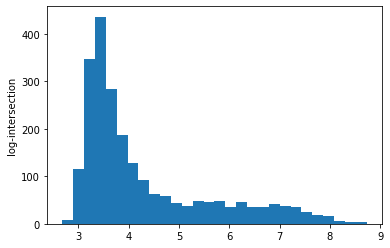

In [38]:
intersections = np.array(intersections)
intersections = np.array(sorted(intersections, key=lambda tup: tup[2], reverse=True))

log_intersections = np.log(1e-10 + intersections[:, 2])
print("log-intersections Mean", np.mean(log_intersections),
      "; log-intersections stddev", np.std(log_intersections))

# for i1, i2, card in intersections:
#     if abs(card) < 1e-2:
#         continue
#     print(hyp_wv.index2word[int(i1)], hyp_wv.index2word[int(i2)], round(card, 2))
    
# Plot intersections
plt.hist(log_intersections, bins="auto")
# plt.plot(range(len(intersections[:, 2])), log_intersections)
ax = plt.gca()
_ = ax.set_ylabel("log-intersection")

In [39]:
hyp_model_fn = os.path.join(ROOT, "models/glove/geometric_emb/glove_ep50_size100_lr0.05_vocab200000_mix-poincare_OPTmixradagrad_COOCCFUNClog_DISTFUNCdist-sq_NUMEMBS50_bias")
# hyp_model_fn = os.path.join(ROOT, "models/glove/geometric_emb/glove_ep50_size100_lr0.01_vocab200000_mix-poincare_OPTmixradagrad_COOCCFUNClog_DISTFUNCcosh-dist-sq_NUMEMBS50_bias")
hyp_model = Glove.load(hyp_model_fn)
hyp_wv = hyp_model.wv

gaussians = get_gaussians(hyp_model, unsupervised=True, scaling_factor=1.0, words_to_use=1000)

1000 words from the TOP-most levels were selected
1000 words from the BOTTOM-most levels were selected
[1.         0.99999994 1.         1.         1.         0.99999994
 1.         1.         1.         1.         0.99999994 1.
 1.         0.99999994 0.99999994 0.9999999  0.99999994 0.99999994
 1.         1.         1.         1.         1.         1.
 0.99999994 1.         1.         0.99999994 0.99999994 1.
 1.         1.         1.         0.99999994 1.         0.99999994
 1.         1.         1.         0.99999994 1.         0.99999994
 1.         0.99999994 0.99999994 1.         0.99999994 0.99999994
 1.         0.99999994]
HP shape (200000, 100)
Gaussians shape (200000, 50, 2)


[0.8386653, 0.48198888, 0.4830028, 0.4303308, 0.55343795, 0.73568404, 0.8042532, 0.5204202, 0.5963595, 0.6160484, 0.6471313, 0.62180656, 0.6250652, 0.56936073, 0.6396852, 0.5167994, 0.53101945, 0.5851721, 0.53213423, 0.52027774, 0.5164506, 0.52432907, 0.49783713, 0.4979282, 0.4772831, 0.49985477, 0.49427533, 0.48467365, 0.49061996, 0.46280453, 0.5074727, 0.49554914, 0.54978675, 0.5124775, 0.6392182, 0.48093092, 0.46264768, 0.5107763]


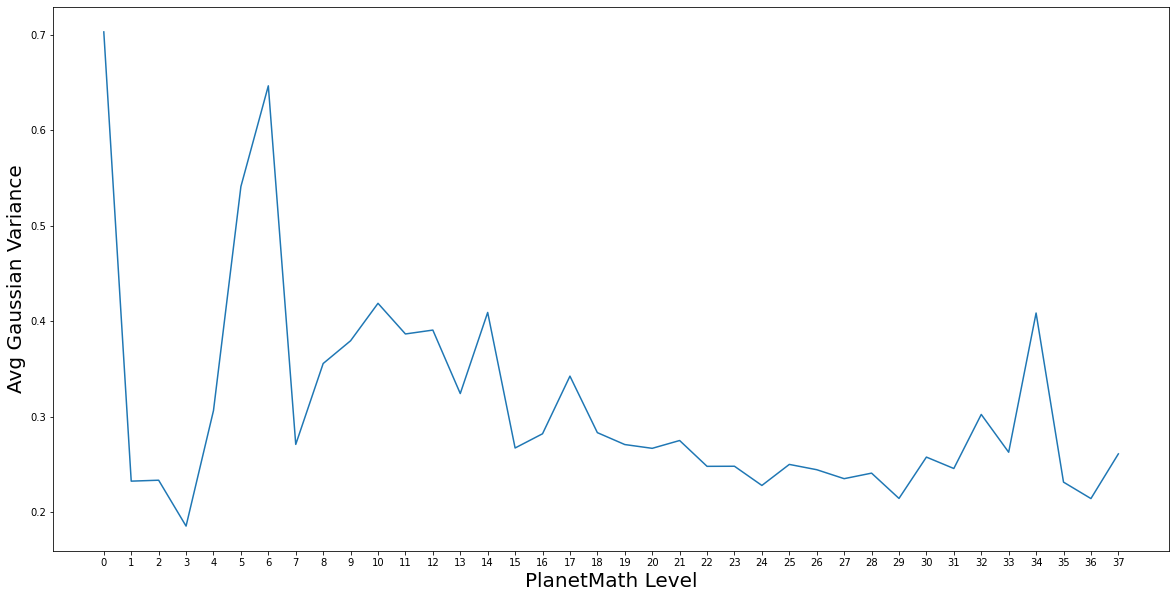

In [40]:
lvl_avg_std = []
lvl_std_std = []
for level, word_list in enumerate(level2words):
    word_idxs = np.array([hyp_wv.vocab[word].index for word in filter(lambda w: w in hyp_wv.vocab, word_list)])
    if word_idxs.size == 0:
        continue
    level_avg_std = np.mean(gaussians[word_idxs][:, 1])
    lvl_avg_std.append(level_avg_std)
    lvl_std_std.append(np.std(gaussians[word_idxs][:, 1]))
    
print(lvl_avg_std)
fig = plt.figure(figsize=(20,10))
plt.plot(range(len(lvl_avg_std)), np.array(lvl_avg_std)**2)
# plt.errorbar(range(len(lvl_avg_std)), lvl_avg_std, lvl_std_std, capsize=10, marker=".", markersize=14)
ax = plt.gca()
_ = ax.set_xticks(range(len(lvl_avg_std)))
_ = ax.set_xlabel("PlanetMath Level", fontsize=20)
_ = ax.set_ylabel("Avg Gaussian Variance", fontsize=20)

In [15]:
wv = hyp_model.wv
wordnet_selected_words_file = os.path.join(ROOT,
                    "poincare_glove/glove_code/data/wordnet_topmost_and_bottommost_words.txt")
top5_bottom5_wn_words = {}
#with open(wordnet_selected_words_file, "r") as f:
#    word_lst1 = f.readline().strip().split(" ")
#    word_lst2 = f.readline().strip().split(" ")
word_lst1, word_lst2 = get_most_pm_words(300)

top5_bottom5_wn_words.update(dict([(word, wv.vocab[word].index) for word in filter(
    lambda w: w in wv.vocab and w not in hyperlex_vocab, word_lst1)]))

top5_bottom5_wn_words.update(dict([(word, wv.vocab[word].index) for word in filter(
    lambda w: w in wv.vocab and w not in hyperlex_vocab, word_lst2)]))

print("Total words in top5 and bottom5 wordnet levels:", len(top5_bottom5_wn_words))
pair_overlap, word_overlap = 0, 0
for w1, w2, _, _, _ in hyperlex_data:
    pairs_are_overlapping = False
    if w1 in top5_bottom5_wn_words:
        pairs_are_overlapping = True
        word_overlap += 1
    if w2 in top5_bottom5_wn_words:
        word_overlap += 1
        pairs_are_overlapping = True
    if pairs_are_overlapping:
        pair_overlap += 1
print("HyperLex overlap:", pair_overlap, "out of", len(hyperlex_data),"pairs;",
      word_overlap, "out of", len(top5_bottom5_wn_words), "words")

pair_overlap, word_overlap = 0, 0
for w1, w2, _ in wbless_data:
    pairs_are_overlapping = False
    if w1 in top5_bottom5_wn_words:
        pairs_are_overlapping = True
        word_overlap += 1
    if w2 in top5_bottom5_wn_words:
        word_overlap += 1
        pairs_are_overlapping = True
    if pairs_are_overlapping:
        pair_overlap += 1
print("WBLESS overlap:", pair_overlap, "out of", len(wbless_data),"pairs;",
      word_overlap, "out of", len(top5_bottom5_wn_words), "words")

Total words in top5 and bottom5 wordnet levels: 472
HyperLex overlap: 0 out of 2281 pairs; 0 out of 472 words
WBLESS overlap: 94 out of 1976 pairs; 94 out of 472 words


In [16]:
gaussians = get_gaussians(hyp_model, scaling_factor=1.0)

wbless_file = os.path.join(ROOT, "data/guess_bless.json")
with open(wbless_file, "r") as f:
    wbless_data = json.load(f)

313 words from the TOP-most levels were selected
400 words from the BOTTOM-most levels were selected
[1.         0.99999994 1.         1.         0.99999994 1.
 1.         1.         0.9999999  1.         0.99999994 0.99999994
 1.         1.         0.99999994 1.         1.         0.99999994
 1.         0.99999994 1.         0.99999994 1.         1.
 0.9999999  1.         1.         0.99999994 1.         1.
 1.         1.         1.         1.         0.99999994 1.
 0.99999994 1.         1.         1.         1.         1.
 0.99999994 1.         0.99999994 1.         0.99999994 0.99999994
 1.         1.        ]
HP shape (200000, 100)
Gaussians shape (200000, 50, 2)


In [17]:
def wbless_get_is_a_score(w1_idx, w2_idx, gaussians, intersections=None, sigma_factor=1, **kwargs):
    v1, v2 = gaussians[w1_idx].reshape(-1, 2), gaussians[w2_idx].reshape(-1, 2)
    log_cardinal_v1 = v1.shape[0] * np.log(2 * sigma_factor) + np.log(v1[:, 1]).sum()
    log_cardinal_v2 = v2.shape[0] * np.log(2 * sigma_factor) + np.log(v2[:, 1]).sum()
    cos_sim = 0.0
    cardinal_intersection = 1.0
    for i in range(v1.shape[0]):
        m1, s1 = v1[i]
        m2, s2 = v2[i]
        s1 *= sigma_factor
        s2 *= sigma_factor
        a, b = m1 - s1, m1 + s1
        c, d = m2 - s2, m2 + s2
        if d > b:
            if c > a:
                cardinal_intersection = cardinal_intersection * max(0, b-c)
            else:
                cardinal_intersection = cardinal_intersection * (b-a)
        else:
            if c > a:
                cardinal_intersection = cardinal_intersection * (d-c)
            else:
                cardinal_intersection = cardinal_intersection * max(0, d-a)

        cos_sim += np.dot(m1, m2) / (np.linalg.norm(m1) + np.linalg.norm(m2) + 1e-10)

    if intersections != None:
        intersections.append((w1_idx, w2_idx, cardinal_intersection))
            
    cardinal_intersection = np.log(1e-10 + cardinal_intersection)
    return log_cardinal_v2-log_cardinal_v1
#     return 1 - log_cardinal_v1 / log_cardinal_v2 if cos_sim > 0.01 else 0.0

def wbless_eval(model, gaussians, sigma_factor=1.0, alpha=600):
    correct_count, total_count = 0.0, 0.0

    instances = []
    for w1, w2, label in wbless_data:
        if w1 not in model.wv.vocab or w2 not in model.wv.vocab:
            continue
        total_count += 1
        model_score = get_nickel_score(model.wv.vocab[w1].index, model.wv.vocab[w2].index, gaussians, 
                                            sigma_factor=sigma_factor, alpha=alpha)
        instances.append((w1, w2, label, model_score))
        
    threshold = np.mean(np.array([model_score for _, _, _, model_score in instances]))
    correct = list(filter(lambda instance: (instance[3] > threshold and instance[2] == 1) \
                          or (instance[3] <= threshold and instance[2] == 0), instances))
            
    print("Accuracy: {:.4f}, from a total of {}/{} pairs".format(
        float(len(correct)) / len(instances), len(instances), len(wbless_data)))
    return float(len(correct)) / len(instances)

_ = wbless_eval(hyp_model, gaussians, sigma_factor=1.0, alpha=600)

Accuracy: 0.6150, from a total of 1418/1976 pairs


Accuracy: 0.6150, from a total of 1418/1976 pairs
Accuracy: 0.6150, from a total of 1418/1976 pairs
Accuracy: 0.6150, from a total of 1418/1976 pairs
Accuracy: 0.6150, from a total of 1418/1976 pairs
Accuracy: 0.6150, from a total of 1418/1976 pairs
Accuracy: 0.6150, from a total of 1418/1976 pairs
Accuracy: 0.6150, from a total of 1418/1976 pairs
Accuracy: 0.6150, from a total of 1418/1976 pairs
Accuracy: 0.6150, from a total of 1418/1976 pairs


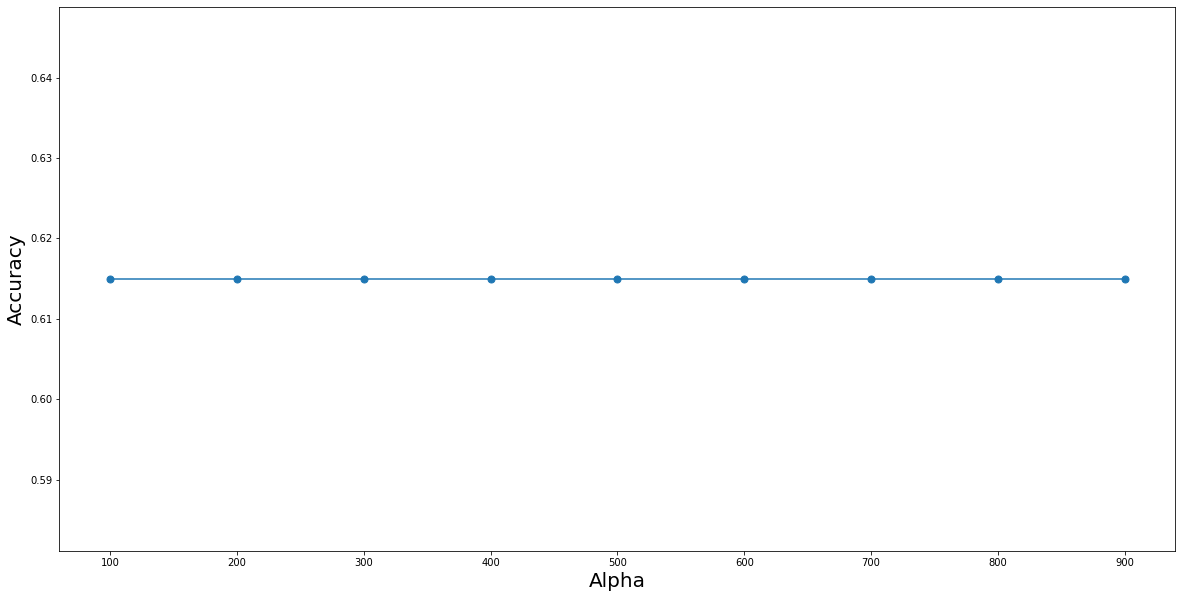

In [19]:
alphas = range(100, 1000, 100)
scores = []
for alpha in alphas:
    scores.append(wbless_eval(hyp_model, gaussians, alpha=alpha))
    
fig = plt.figure(figsize=(20,10))
plt.plot(alphas, scores, marker=".", markersize=14)
ax = plt.gca()
_ = ax.set_xticks(alphas)
_ = ax.set_xlabel("Alpha", fontsize=20)
_ = ax.set_ylabel("Accuracy", fontsize=20)

In [18]:
# Get vocabulary from WordNet + labels for each section
def read_word_dict():
    result_dict = dict([(str(level), word_list[:50] + word_list[50::10])\
                        for level, word_list in enumerate(level2words)])
    return result_dict

def HSVToRGB(h, s, v):
    (r, g, b) = colorsys.hsv_to_rgb(h, s, v)
    return (int(255*r), int(255*g), int(255*b))

def get_colors(word_dict):
    labels = word_dict.keys()
    huePartition = 1.0 / (len(labels) + 1)
    return dict(zip(labels, [HSVToRGB(huePartition * value, 1.0, 1.0)\
                             for value in range(0, len(labels))]))

def plot_halfplane_wordnet_per_level(model, gaussians,
    word_dict, right_offset=None, left_offset=None, ratio_words=0.1, aggregate="w"):
    colors = get_colors(labeled_word_dict)

    wv = model.wv
    if aggregate == "w":
        vectors = model.wv.vectors    
    elif aggregate == "c":
        vectors = model.trainables.syn1neg   
    else:
        return None 
    
    embeddings = np.array([vectors[i] for i in range(len(wv.index2entity))])

    traces = []
    small_emb_size = int(model.vector_size // model.num_embs)
    rows = int(np.ceil(model.num_embs / PLOTS_PER_ROW))
    fig = tools.make_subplots(rows=rows, cols=PLOTS_PER_ROW)
    
    layout = {
        'width': PLOTS_PER_ROW * 300,
        'height': rows * 300
    }
    
    for level, words in word_dict.items():
        if int(level) in range(4, 16):
            continue
            
        idxs = [wv.vocab[w].index for w in filter(lambda w: w in wv.vocab, words)]
        idxs = idxs[:int(len(idxs) * ratio_words)]

        embs = gaussians[idxs, :]
        print("embs shape: ", embs.shape)

        params = {}
        for i in range(model.num_embs):
            print("model.num_embs is: ", model.num_embs)
            row = int(i / PLOTS_PER_ROW) + 1
            col = i % PLOTS_PER_ROW + 1

            trace = go.Scatter(
                x=embs[:, small_emb_size * i],
                y=embs[:, small_emb_size * i + 1],
                text=[wv.index2word[idx] for idx in idxs],
                textposition='top right',
                name=level,
                mode="markers",
                marker=dict(color="rgb"+str(colors[level])))
            fig.append_trace(trace, row, col)
            
#             if i == 0:
#                 layout["xaxis"] = {"range": (-1, 1)}
#                 layout["yaxis"] = {"range": (0, 3)}
#             else:
            layout["xaxis"+str(i+1)] = {"range": (-1, 1)}
            layout["yaxis"+str(i+1)] = {"range": (0, 3)}

    fig["layout"].update(layout)
    
    return iplot(fig)

labeled_word_dict = read_word_dict()
for lvl in labeled_word_dict:
    print(len(labeled_word_dict[lvl]))

1
7
1
1
1
2
2
5
5
10
12
12
22
8
17
28
40
51
52
57
64
78
76
74
77
76
73
67
65
63
58
53
51
34
20
18
9
10
6
5


In [21]:
halfplane = np.copy(gaussians)
halfplane[:, :, 0] *= np.sqrt(2)
plot_halfplane_wordnet_per_level(hyp_model, halfplane.reshape(-1, 20), labeled_word_dict, ratio_words=1,
                       left_offset=None, right_offset=None, aggregate="w")

embs shape:  (1, 20)
model.num_embs is:  50
model.num_embs is:  50
model.num_embs is:  50
model.num_embs is:  50
model.num_embs is:  50
model.num_embs is:  50
model.num_embs is:  50
model.num_embs is:  50
model.num_embs is:  50
model.num_embs is:  50
model.num_embs is:  50


/home/luis/.local/lib/python3.8/site-packages/plotly/tools.py:461: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



IndexError: index 20 is out of bounds for axis 1 with size 20

In [2]:
# Get vocabulary of the Google word analogy benchmark + labels for each section

def compute_poincare_aggregate(model):
    """
    Precompute the average between the target and the context vector, for Poincare embeddings.
    We take as average the mid point between w and c on the geodesic that connects the 2 points
    (see page 89 in Ungar book).
    """
    if model.poincare and getattr(model.wv, 'agg_vectors', None) is None:
        print("precomputing aggregated vectors w+c for Poincare embeddings")
        gamma_w_sq = 1 / (1 - np.sum(model.wv.vectors * model.wv.vectors, axis=1))
        gamma_c_sq = 1 / (1 - np.sum(model.trainables.syn1neg * model.trainables.syn1neg, axis=1))
        denominator = gamma_w_sq + gamma_c_sq - 1
        agg = (model.wv.vectors * (gamma_w_sq / denominator)[:, None] +
               model.trainables.syn1neg * (gamma_c_sq / denominator)[:, None])

        return model.wv.moebius_mul_mat(agg, 0.5)

def HSVToRGB(h, s, v):
    (r, g, b) = colorsys.hsv_to_rgb(h, s, v)
    return (int(255*r), int(255*g), int(255*b))

def get_colors(word_dict):
    labels = word_dict.keys()
    huePartition = 1.0 / (len(labels) + 1)
    return dict(zip(labels, [HSVToRGB(huePartition * value, 1.0, 1.0) for value in range(0, len(labels))]))

def plot_wordnet_embeddings(model, gaussians, word_dict, left_offset=None, right_offset=None, ratio_words=1, aggregate="w"):
    colors = get_colors(labeled_word_dict)
    if aggregate == "w+c":
        vectors = compute_poincare_aggregate(model)
    elif aggregate == "w":
        vectors = model.wv.vectors    
    elif aggregate == "c":
        vectors = model.trainables.syn1neg   
    else:
        return None   
    wv = model.wv

    embeddings = gaussians.reshape(-1, 20)  # np.array([vectors[i] for i in range(len(wv.index2entity))])
    traces = []

    fig = tools.make_subplots(rows=1, cols=4)
    annotations = []
    for label, values in word_dict.items():
        dim, col, ax, ay, words = values
        idxs = [wv.vocab[w].index for w in filter(lambda w: w in wv.vocab, words+[label])]
        idxs = idxs[:int(len(idxs) * ratio_words)]
        print(label, col, dim)
        label_idx = wv.vocab[label].index
        
        embs = embeddings[idxs, :]
        small_emb_size = int(model.vector_size / model.num_embs)
        
        trace = go.Scatter(
            x=embs[:, small_emb_size * dim],
            y=embs[:, small_emb_size * dim + 1],
            text=[wv.index2word[idx] for idx in idxs],
            textposition='top right',
            name=label,
            mode="markers+text",
            marker=dict(color="rgb"+str(colors[label])))
        fig.append_trace(trace, 1, col)

    layout = {
        'width': 4 * 600,
        'height': 1 * 600
    }

    layout["annotations"] = annotations

    for i, trace in enumerate(fig['data']):
#         if i > 0: 
#             trace['showlegend'] = False
        layout['xaxis'+str(i+1)] = {
                'range': [-1, 1],
            }
        layout['yaxis'+str(i+1)] = {
                'range': [0, 3],
            }
        
    fig["layout"].update(layout)
    
    return iplot(fig)

def read_word_dict():
    result_dict = {
        #"mathematics": (0, 1, 0, -20, ["geometry", "inequality", "arithmetic", "calculus", "algebra", "equation", "theorem"]),
        "geometry": (2, 2, 0, -20, ['riemannian_metric', 'inner_product', 'geodesic', 'connection', 'hyperbolic', 'euclidean', 'fisher']),
        #"number": (4, 3, 0, -20, ["one", "two", "three", "four", "five", "six", "seven", "eight", "nine", "ten"]),
        'bundles': (4, 3, 0, -20,['vector_bundle', 'principal_bundle','topological_group' ,'fibre_bundle', 'polynomial']),
        #"analysis": (4, 3, 0, -20, ["bochner", "integral", "sum"]),
        #"chemistry": ["chemical", "oxygen", "carbon", "dioxide", "nitrogen", "chlorium", "zinc", "organic"],
        'lie_group': (1, 1, 0, -20,['group', 'abelian_group', 'compact_lie_group','lie_group','topological_group' ,'minimal_polynomial', 'polynomial']),
    }
    return result_dict
labeled_word_dict = read_word_dict()
len(labeled_word_dict)

3

In [3]:
plot_wordnet_embeddings(hyp_model, gaussians, labeled_word_dict, ratio_words=1)

NameError: name 'hyp_model' is not defined